In [1]:
#下载数据集：通过moxing接口，从OBS上下载数据集到Notebook
import moxing as mox 
mox.file.copy_parallel(src_url="obs://professional-construction/ComputerVision/Unet",dst_url="./") 

INFO:root:Using MoXing-v2.0.0.rc2.4b57a67b-4b57a67b
INFO:root:Using OBS-Python-SDK-3.20.9.1


In [2]:
#导入实验所需要的库
import os
import argparse
import ast
import numpy as np
import pandas as pd
import cv2
import mindspore
import mindspore.nn as nn
import mindspore.ops.operations as F
from mindspore import Model, context
from mindspore.nn.loss.loss import _Loss
from mindspore.communication.management import init, get_group_size 
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint 
from mindspore.context import ParallelMode
from mindspore.train.serialization import load_checkpoint, load_param_into_net 
from mindspore.common.initializer import TruncatedNormal 
from mindspore.nn import CentralCrop
from PIL import Image, ImageSequence
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_vision
from mindspore.dataset.vision.utils import Inter
from mindspore.communication.management import get_rank, get_group_size
from collections import deque
import time
from mindspore.train.callback import Callback
from mindspore.common.tensor import Tensor
from scipy.special import softmax
from matplotlib import pyplot as plt
device_id = 2
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
mindspore.set_seed(1)

(30, 512, 512)
(30, 512, 512)


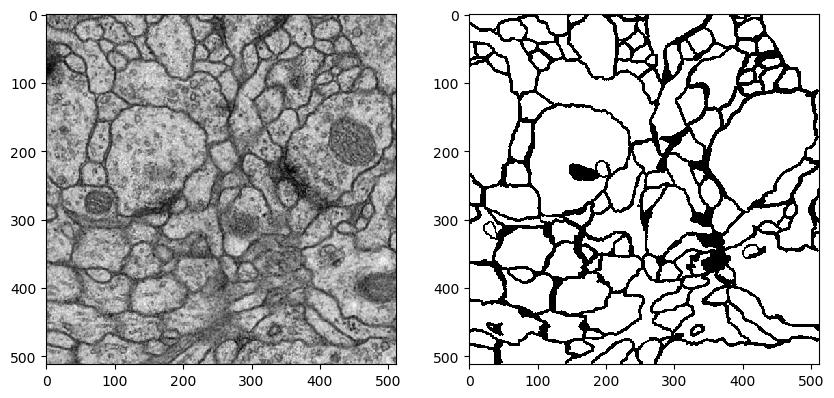

In [3]:
# 展示数据集图像和标签
#打印图像和标签的形状，并展示第一张图像和标签

image= np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/train-volume.tif"))])
label= np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/train-labels.tif"))])
print(image.shape)
print(label.shape)

#设置图像大小，单位为“英寸”
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(image[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(label[0],cmap='gray')
plt.show()


In [4]:
#下面使用OTSU算法，即大津阈值法进行图像分割。
#大津阈值法是具有统计意义上的最佳分割阈值。
#其核心思想就是使类间方差最大，按照大津阈值法求得的阈值进行图像二值分割以区分前后背景，前景与背景图像的类间方差最大。
#该算法要求被分割的物体颜色纹理比较紧凑，类内方差小。

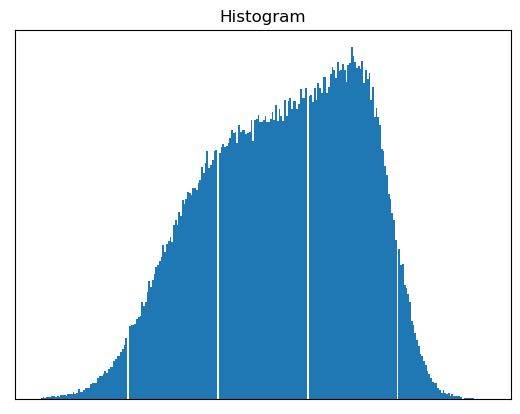

In [5]:
#采用 OpenCV 和 matplotlib 绘制一张训练集中的直方图以便观察
plt.hist(image[0].ravel(), 256)
plt.title("Histogram")
plt.xticks([])
plt.yticks([])
plt.show()
#观察直方图，发现该数据集的图像的直方图很连续，并没有出现明显的波谷，使用传统基于统计的阈值分割算法可能并不能取得好的效果

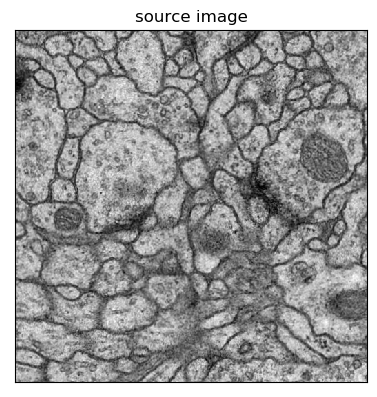

In [6]:
#采用 OpenCV 中的 python 接口实现基于大津阈值法的图像二值化分割

#显示原图
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image[0],cmap='gray')
plt.title("source image")
plt.xticks([])
plt.yticks([])

plt.show()

In [7]:
ret1,th1 = cv2.threshold(src=image[0], thresh=0,
     maxval=255, type=cv2.THRESH_OTSU)
type(th1)

numpy.ndarray

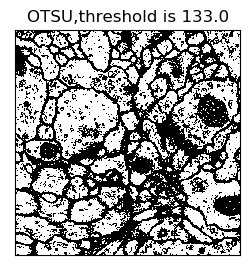

In [8]:
#显示经过大津阈值法后的二值化图像
plt.subplot(122)
plt.imshow(th1, "gray")
plt.title("OTSU,threshold is " + str(ret1))
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
# 通过分割结果我们观察到，分割结果并不理想。下面我们尝试用深度学习的方法解决以上的图像分割问题。
# 使用深度学习进行图像分割，采用了分类的思路，对每个像素点进行分类，判断像素点是属于目标前景还是背景。


In [10]:
# 超参数设置
cfg_unet = {
    'name': 'Unet',
    'lr': 0.0001,
    'epochs': 400,
    'distribute_epochs': 1600,
    'batchsize': 16,
    'cross_valid_ind': 1,
    'num_classes': 2,
    'num_channels': 1,
    'keep_checkpoint_max': 10,
    'weight_decay': 0.0005,
    'loss_scale': 1024.0,
    'FixedLossScaleManager': 1024.0,
    'resume': False,
    'resume_ckpt': './',
}

In [11]:
# 各个模块搭建：两层卷积，下采样，上采样，输出模块，用于搭建U-net网络。
# 定义两个卷积层
class DoubleConv(nn.Cell):
    #由于所有的模块都要用到，因此为了简便，定义了这个类
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        #截断高斯分布初始化
        init_value_0 = TruncatedNormal(0.06)
        init_value_1 = TruncatedNormal(0.06)   
        if not mid_channels:
            mid_channels = out_channels
        #定义两个卷积层，根据原论文，激活函数用 ReLU,卷积核大小为 3，不用 padding，因此每经过一个卷积层，特征图大小会减小 2 像素。
        self.double_conv = nn.SequentialCell(
            [nn.Conv2d(in_channels, mid_channels, kernel_size=3, has_bias=True,
                        weight_init=init_value_0, pad_mode="valid"),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, has_bias=True, weight_init=init_value_1, pad_mode="valid"),
            nn.ReLU()]
)

    def construct(self, x):
        return self.double_conv(x)


In [12]:
# 下采样用一个最大池化接两个卷积层
class Down(nn.Cell):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.SequentialCell(
            [nn.MaxPool2d(kernel_size=2, stride=2),
                DoubleConv(in_channels, out_channels)]
        )


    def construct(self, x):
        return self.maxpool_conv(x)


In [13]:
class Up1(nn.Cell):
    # 第一个上采样模块采用一个转置卷积接两个卷积
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        #U-Net 网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为 64，解码器为56。 
        self.factor = 56.0 / 64.0
        #中心裁剪
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        #转置卷积，常用的上采样方式。
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


In [14]:
class Up2(nn.Cell):
# 第二个上采样模块采用一个转置卷积接两个卷积
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        #U-Net 网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为 136，解码器为104。
        self.factor = 104.0 / 136.0
        #中心裁剪
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        #转置卷积，常用的上采样方式。
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
    
    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


In [15]:
class Up3(nn.Cell):
    # 第三个上采样模块采用一个转置卷积接两个卷积
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        #U-Net 网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #根据原论文，编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为 280，解码器为200。
        self.factor = 200 / 280
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)



class Up4(nn.Cell):
     # 第四个上采样模块采用一个转置卷积接两个卷积
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        #编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为 568，解码器为392
        self.factor = 392 / 568
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
    
    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)



In [16]:
class OutConv(nn.Cell):
#最后的输出层，通道数为 2，意味着二分类。
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        init_value = TruncatedNormal(0.06)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=True, weight_init=init_value)
        
    def construct(self, x):
        x = self.conv(x)
        return x




In [17]:
# 使用 MindSpore 搭建 Unet 类，用于构建网络。要求：网络结构和原论文保持一致。

In [18]:
#根据原论文搭建 U-Net 网络
class UNet(nn.Cell):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up1(1024, 512)
        self.up2 = Up2(512, 256)
        self.up3 = Up3(256, 128)
        self.up4 = Up4(128, 64)
        self.outc = OutConv(64, n_classes)
    
    def construct(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [19]:
# 图像分割实现的是像素级别的分类。对应本实验来说，每个像素有两种可能分类，即前景和背景。损失函数会对所有位置的多分类损失求平均

In [20]:
# 重新构建一个类：将 MindSpore 的 nn.SoftmaxCrossEntropyWithLogits 损失函数用于 Unet，计算输出特征图各个位置平均的损失值
class CrossEntropyWithLogits(_Loss):
    #重写损失函数。
    def __init__(self):
        super(CrossEntropyWithLogits, self).__init__()
        self.transpose_fn = F.Transpose()
        self.reshape_fn = F.Reshape()
        self.softmax_cross_entropy_loss = nn.SoftmaxCrossEntropyWithLogits()
        self.cast = F.Cast()
    
    def construct(self, logits, label):
    # NCHW->NHWC
        logits = self.transpose_fn(logits, (0, 2, 3, 1))
        logits = self.cast(logits, mindspore.float32)
        label = self.transpose_fn(label, (0, 2, 3, 1))
    #损失函数计算所有像素点的交叉熵损失，取平均后就得到了总损失。
        loss = self.reduce_mean(self.softmax_cross_entropy_loss(self.reshape_fn(logits, (-1, 2)),self.reshape_fn(label, (-1, 2))))
        return self.get_loss(loss)


In [21]:
def _load_multipage_tiff(path):
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])
def _get_val_train_indices(length, fold, ratio=0.8):
#将训练数据分为训练集和验证集
    assert 0 < ratio <= 1, "Train/total data ratio must be in range (0.0, 1.0]"
    np.random.seed(0)
    indices = np.arange(0, length, 1, dtype=np.int)
    #打乱数据，利于模型训练
    np.random.shuffle(indices)


    if fold is not None:
        #使用 deque 方式切分数据
        indices = deque(indices)
        indices.rotate(fold * round((1.0 - ratio) * length))
        indices = np.array(indices)
        train_indices = indices[:round(ratio * len(indices))]
        val_indices = indices[round(ratio * len(indices)):]

    else:
        train_indices = indices
        val_indices = []
    return train_indices, val_indices


def data_post_process(img, mask):
    img = np.expand_dims(img, axis=0)
    mask = (mask > 0.5).astype(np.int)
    mask = (np.arange(mask.max() + 1) == mask[..., None]).astype(int)
    mask = mask.transpose(2, 0, 1).astype(np.float32)
    return img, mask


def train_data_augmentation(img, mask):
#原数据只有 30 张训练数据，因此需要数据增强
    #生成随机数，如果随机数大于 0.5 就旋转图像。
    h_flip = np.random.random()
    if h_flip > 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)
    v_flip = np.random.random()
    #生成随机数，如果随机数大于 0.5 就翻转图像。
    if v_flip > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    #生成随机数用于裁剪图像
    left = int(np.random.uniform()*0.3*572)
    right = int((1-np.random.uniform()*0.3)*572)
    top = int(np.random.uniform()*0.3*572)
    bottom = int((1-np.random.uniform()*0.3)*572)
    #裁剪
    img = img[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    
    #改变亮度
    brightness = np.random.uniform(-0.2, 0.2)
    img = np.float32(img+brightness*np.ones(img.shape))
    img = np.clip(img, -1.0, 1.0)

    return img, mask


def create_dataset(data_dir, repeat=400, train_batch_size=16, augment=False, cross_val_ind=1, run_distribute=False):
    #创建数据集
    images = _load_multipage_tiff(os.path.join(data_dir, 'train-volume.tif'))
    masks = _load_multipage_tiff(os.path.join(data_dir, 'train-labels.tif'))
    
    train_indices, val_indices = _get_val_train_indices(len(images), cross_val_ind)
    train_images = images[train_indices]
    train_masks = masks[train_indices]
    train_images = np.repeat(train_images, repeat, axis=0)
    train_masks = np.repeat(train_masks, repeat, axis=0)
    val_images = images[val_indices]
    val_masks = masks[val_indices]
    
    train_image_data = {"image": train_images}
    train_mask_data = {"mask": train_masks}
    valid_image_data = {"image": val_images}
    valid_mask_data = {"mask": val_masks}


    ds_train_images = ds.NumpySlicesDataset(data=train_image_data, sampler=None, shuffle=False)
    ds_train_masks = ds.NumpySlicesDataset(data=train_mask_data, sampler=None, shuffle=False)

    if run_distribute:
        rank_id = get_rank()
        rank_size = get_group_size()
        ds_train_images = ds.NumpySlicesDataset(data=train_image_data,sampler=None,shuffle=False,num_shards=rank_size,shard_id=rank_id)
        ds_train_masks = ds.NumpySlicesDataset(data=train_mask_data,sampler=None,shuffle=False,num_shards=rank_size,shard_id=rank_id)
    
    ds_valid_images = ds.NumpySlicesDataset(data=valid_image_data, sampler=None, shuffle=False)
    ds_valid_masks = ds.NumpySlicesDataset(data=valid_mask_data, sampler=None, shuffle=False)

    c_resize_op = c_vision.Resize(size=(388, 388), interpolation=Inter.BILINEAR)
    c_pad = c_vision.Pad(padding=92)
    c_rescale_image = c_vision.Rescale(1.0/127.5, -1)
    c_rescale_mask = c_vision.Rescale(1.0/255.0, 0)
    
    c_trans_normalize_img = [c_rescale_image, c_resize_op, c_pad]
    c_trans_normalize_mask = [c_rescale_mask, c_resize_op, c_pad]
    c_center_crop = c_vision.CenterCrop(size=388)


    train_image_ds = ds_train_images.map(input_columns="image", operations=c_trans_normalize_img)
    train_mask_ds = ds_train_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    train_ds = ds.zip((train_image_ds, train_mask_ds))
    train_ds = train_ds.project(columns=["image", "mask"])
    
    if augment:
        augment_process = train_data_augmentation
        c_resize_op = c_vision.Resize(size=(572, 572), interpolation=Inter.BILINEAR)
        train_ds = train_ds.map(input_columns=["image", "mask"], operations=augment_process)
        train_ds = train_ds.map(input_columns="image", operations=c_resize_op)
        train_ds = train_ds.map(input_columns="mask", operations=c_resize_op)
    
    train_ds = train_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    train_ds = train_ds.map(input_columns=["image", "mask"], operations=post_process)
    train_ds = train_ds.shuffle(repeat*24)
    train_ds = train_ds.batch(batch_size=train_batch_size, drop_remainder=True)
    
    valid_image_ds = ds_valid_images.map(input_columns="image", operations=c_trans_normalize_img)
    valid_mask_ds = ds_valid_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    valid_ds = ds.zip((valid_image_ds, valid_mask_ds))
    valid_ds = valid_ds.project(columns=["image", "mask"])
    valid_ds = valid_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    valid_ds = valid_ds.map(input_columns=["image", "mask"], operations=post_process)
    valid_ds = valid_ds.batch(batch_size=1, drop_remainder=True)
    
    return train_ds, valid_ds


In [22]:
#下面进行模型训练，定义类用于打印损失和速度
class StepLossTimeMonitor(Callback):
#创建 callback 用于监控训练。
    def __init__(self, batch_size, per_print_times=1):
        super(StepLossTimeMonitor, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.batch_size = batch_size

    def step_begin(self, run_context):
        self.step_time = time.time()

    def step_end(self, run_context):
        step_seconds = time.time() - self.step_time
        step_fps = self.batch_size*1.0/step_seconds
    
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format( cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            print("step: %s, loss is %s, fps is %s" % (cur_step_in_epoch, loss, step_fps), flush=True)


In [23]:
#定义类用于训练模型
def train_net(data_dir, cross_valid_ind=1, epochs=400, batch_size=16, lr=0.0001, run_distribute=False, cfg=None):
    if run_distribute:
        init()
        group_size = get_group_size()
        parallel_mode = ParallelMode.DATA_PARALLEL
        context.set_auto_parallel_context(parallel_mode=parallel_mode,device_num=group_size,gradients_mean=False)


    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    
    if cfg['resume']:
        param_dict = load_checkpoint(cfg['resume_ckpt'])
        load_param_into_net(net, param_dict)
    
    criterion = CrossEntropyWithLogits()
    train_dataset, _ = create_dataset(data_dir, epochs, batch_size, True, cross_valid_ind, run_distribute)
    train_data_size = train_dataset.get_dataset_size()
    print("dataset length is:", train_data_size)
    ckpt_config = CheckpointConfig(save_checkpoint_steps=train_data_size,keep_checkpoint_max=cfg['keep_checkpoint_max'])
    ckpoint_cb = ModelCheckpoint(prefix='ckpt_unet_medical_adam', directory='./ckpt_{}/'.format(device_id),config=ckpt_config)
    
    optimizer = nn.Adam(params=net.trainable_params(), learning_rate=lr, weight_decay=cfg['weight_decay'],loss_scale=cfg['loss_scale'])
    loss_scale_manager =mindspore.train.loss_scale_manager.FixedLossScaleManager(cfg['FixedLossScaleManager'], False)


    model = Model(net, loss_fn=criterion, loss_scale_manager=loss_scale_manager, optimizer=optimizer, amp_level="O3")


    print("============== Starting Training ==============")
    model.train(2, train_dataset, callbacks=[StepLossTimeMonitor(batch_size=batch_size), ckpoint_cb], dataset_sink_mode=False)

    print("============== End Training ==============")



In [24]:
# 下面开始训练模型
data_url = './data'
run_distribute = False
epoch_size = cfg_unet['epochs'] if not run_distribute else cfg_unet['distribute_epochs']
train_net(data_dir=data_url, cross_valid_ind=cfg_unet['cross_valid_ind'], epochs=epoch_size, batch_size=cfg_unet['batchsize'], lr=cfg_unet['lr'], run_distribute=run_distribute, cfg=cfg_unet)


[WARNING] ME(6191:281473004133984,MainProcess):2022-01-16-12:20:58.228.895 [mindspore/nn/loss/loss.py:103] '_Loss' is deprecated from version 1.3 and will be removed in a future version, use 'LossBase' instead.


dataset length is: 600
============== Starting Training ==============
step: 1, loss is 0.7005973, fps is 0.08024982874993364
step: 2, loss is 0.6895514, fps is 66.4657414853874
step: 3, loss is 0.6818066, fps is 68.03074867529898
step: 4, loss is 0.66247696, fps is 65.50529439325317
step: 5, loss is 0.6227852, fps is 68.30342255710114
step: 6, loss is 0.5464559, fps is 66.8126833746004
step: 7, loss is 0.60736775, fps is 68.20561021221238
step: 8, loss is 0.57534397, fps is 65.31505142759259
step: 9, loss is 0.53743446, fps is 68.16937496635153
step: 10, loss is 0.55008674, fps is 62.45014558919188
step: 11, loss is 0.5756577, fps is 68.32713685003614
step: 12, loss is 0.5659322, fps is 66.87080393798078
step: 13, loss is 0.5452884, fps is 68.01323599907977
step: 14, loss is 0.5340688, fps is 65.9815040222754
step: 15, loss is 0.5435245, fps is 68.13027305361987
step: 16, loss is 0.5447374, fps is 67.09048120814897
step: 17, loss is 0.55229306, fps is 68.07829897743872
step: 18, loss 

step: 150, loss is 0.31695825, fps is 68.1741533197748
step: 151, loss is 0.31445962, fps is 68.7949596664654
step: 152, loss is 0.31055474, fps is 67.98354022858092
step: 153, loss is 0.29906926, fps is 68.80031986385282
step: 154, loss is 0.29424226, fps is 64.71112276807453
step: 155, loss is 0.27024645, fps is 68.14106485035315
step: 156, loss is 0.2905362, fps is 68.09273594162048
step: 157, loss is 0.29024354, fps is 68.71479753314718
step: 158, loss is 0.2617591, fps is 68.15061429003751
step: 159, loss is 0.2776014, fps is 68.90621367756562
step: 160, loss is 0.29072195, fps is 66.36642282782512
step: 161, loss is 0.27975628, fps is 68.72964652433691
step: 162, loss is 0.26405284, fps is 68.05068548714205
step: 163, loss is 0.27801746, fps is 68.74422025566194
step: 164, loss is 0.27421635, fps is 67.84587372628867
step: 165, loss is 0.27167428, fps is 68.69102436418017
step: 166, loss is 0.2894872, fps is 67.97617197827076
step: 167, loss is 0.26879647, fps is 68.7341517523357

step: 298, loss is 0.22759683, fps is 69.18796226609619
step: 299, loss is 0.22150253, fps is 68.94139522651602
step: 300, loss is 0.23198175, fps is 69.08326367585596
step: 301, loss is 0.21354887, fps is 68.93473841643615
step: 302, loss is 0.25468466, fps is 69.0497843894017
step: 303, loss is 0.23477219, fps is 68.83878260691169
step: 304, loss is 0.22321884, fps is 69.09379041092505
step: 305, loss is 0.22796437, fps is 68.81125443471484
step: 306, loss is 0.24520749, fps is 69.08561057539374
step: 307, loss is 0.23385963, fps is 69.05205796314074
step: 308, loss is 0.2369598, fps is 69.0639966820728
step: 309, loss is 0.24071437, fps is 68.8106194291011
step: 310, loss is 0.23869869, fps is 69.03138816026333
step: 311, loss is 0.24356553, fps is 69.16257757861953
step: 312, loss is 0.2193587, fps is 68.89645132610718
step: 313, loss is 0.22963503, fps is 68.93218934023865
step: 314, loss is 0.2370079, fps is 69.08731751157909
step: 315, loss is 0.24343573, fps is 68.9743441108212

step: 445, loss is 0.21565303, fps is 68.8527668795246
step: 446, loss is 0.21737424, fps is 69.04914497376274
step: 447, loss is 0.22167677, fps is 69.06314377952934
step: 448, loss is 0.20154575, fps is 68.85248431273573
step: 449, loss is 0.19226806, fps is 69.02556591430852
step: 450, loss is 0.20672418, fps is 68.49408844470572
step: 451, loss is 0.21639244, fps is 69.20087567245396
step: 452, loss is 0.21064867, fps is 68.83617001416545
step: 453, loss is 0.22355099, fps is 68.85997311634875
step: 454, loss is 0.20745893, fps is 68.86195156288801
step: 455, loss is 0.21390092, fps is 68.4984230091639
step: 456, loss is 0.19814655, fps is 68.82028689449223
step: 457, loss is 0.20154314, fps is 68.55482231220911
step: 458, loss is 0.21496518, fps is 68.7797299804142
step: 459, loss is 0.19510676, fps is 68.92164100162474
step: 460, loss is 0.20825988, fps is 69.03394457851651
step: 461, loss is 0.2143164, fps is 68.98185944772462
step: 462, loss is 0.21463719, fps is 68.91831434307

step: 592, loss is 0.19438061, fps is 62.211165568304125
step: 593, loss is 0.2072944, fps is 58.544301103034826
step: 594, loss is 0.1972435, fps is 51.8252784371993
step: 595, loss is 0.19791198, fps is 55.89401030279558
step: 596, loss is 0.19530746, fps is 68.2600006509781
step: 597, loss is 0.2111458, fps is 66.0993289489625
step: 598, loss is 0.20687509, fps is 67.85232189095925
step: 599, loss is 0.20096852, fps is 65.21673098396231
step: 600, loss is 0.20373085, fps is 65.68179562642467
step: 1, loss is 0.18838227, fps is 66.86107684919688
step: 2, loss is 0.2040316, fps is 68.50863237672117
step: 3, loss is 0.20774177, fps is 69.11720255462988
step: 4, loss is 0.19958234, fps is 68.41664823093431
step: 5, loss is 0.20205961, fps is 69.16386062694788
step: 6, loss is 0.19792825, fps is 68.75647542050147
step: 7, loss is 0.19657905, fps is 69.17284329833574
step: 8, loss is 0.21474913, fps is 68.82586279925296
step: 9, loss is 0.20250246, fps is 69.23135900435553
step: 10, loss 

step: 142, loss is 0.18509302, fps is 68.5840380749542
step: 143, loss is 0.19421461, fps is 68.97732168993701
step: 144, loss is 0.20081598, fps is 68.33068497809329
step: 145, loss is 0.19818765, fps is 68.93013605484101
step: 146, loss is 0.19774699, fps is 68.58249609356237
step: 147, loss is 0.19128338, fps is 68.9937029714778
step: 148, loss is 0.18642262, fps is 68.65968019660062
step: 149, loss is 0.18692875, fps is 68.91647420184006
step: 150, loss is 0.21333443, fps is 68.53703881482329
step: 151, loss is 0.18897559, fps is 68.91916367217708
step: 152, loss is 0.1897228, fps is 68.59918121182695
step: 153, loss is 0.18726404, fps is 68.4194383414301
step: 154, loss is 0.19025965, fps is 68.75563009643983
step: 155, loss is 0.19438212, fps is 68.72746451683601
step: 156, loss is 0.20277858, fps is 68.51849499758532
step: 157, loss is 0.18694855, fps is 68.8666861643449
step: 158, loss is 0.21243614, fps is 68.59160880759376
step: 159, loss is 0.20255376, fps is 68.878278085744

step: 290, loss is 0.18753637, fps is 68.51017103841984
step: 291, loss is 0.19802324, fps is 69.02159031068983
step: 292, loss is 0.19920845, fps is 68.56378757228386
step: 293, loss is 0.1891777, fps is 68.87601594099819
step: 294, loss is 0.1972527, fps is 68.65061961532088
step: 295, loss is 0.1874994, fps is 69.0073245044417
step: 296, loss is 0.20019644, fps is 68.69503229570789
step: 297, loss is 0.19166155, fps is 68.97937778746262
step: 298, loss is 0.19577602, fps is 68.29105037300712
step: 299, loss is 0.19879486, fps is 68.98157582037145
step: 300, loss is 0.19382094, fps is 68.53220945823814
step: 301, loss is 0.18960516, fps is 69.04800826408866
step: 302, loss is 0.19122487, fps is 68.60177584595978
step: 303, loss is 0.18461648, fps is 67.85492894373638
step: 304, loss is 0.1884736, fps is 68.48038923561082
step: 305, loss is 0.19395103, fps is 68.98334852959468
step: 306, loss is 0.18046047, fps is 68.66143639987395
step: 307, loss is 0.17669089, fps is 68.993915766574

step: 438, loss is 0.1782507, fps is 68.69693095283672
step: 439, loss is 0.18991849, fps is 69.15844363558418
step: 440, loss is 0.17739438, fps is 68.47486916497202
step: 441, loss is 0.17772283, fps is 69.13578700336464
step: 442, loss is 0.18464266, fps is 68.68722780779532
step: 443, loss is 0.18161674, fps is 69.11015589438973
step: 444, loss is 0.17337933, fps is 68.76697325922648
step: 445, loss is 0.1845365, fps is 69.08589505890056
step: 446, loss is 0.17489894, fps is 68.81294784031762
step: 447, loss is 0.16609958, fps is 68.992000657959
step: 448, loss is 0.1865537, fps is 68.94458245237699
step: 449, loss is 0.16789313, fps is 69.00647300105604
step: 450, loss is 0.17742097, fps is 66.92408659690594
step: 451, loss is 0.16945916, fps is 69.15730332447083
step: 452, loss is 0.17589848, fps is 68.49310974800723
step: 453, loss is 0.1766862, fps is 69.15195861734959
step: 454, loss is 0.18002963, fps is 68.80956111245546
step: 455, loss is 0.17291263, fps is 69.1101558943897

step: 586, loss is 0.17548235, fps is 69.0938615484247
step: 587, loss is 0.17124023, fps is 68.81499414995996
step: 588, loss is 0.16896334, fps is 69.13243964072362
step: 589, loss is 0.17848301, fps is 68.60142520825603
step: 590, loss is 0.18279205, fps is 69.098130066484
step: 591, loss is 0.17750984, fps is 69.06207768097329
step: 592, loss is 0.17303741, fps is 69.00845987497853
step: 593, loss is 0.17882133, fps is 68.81414738638193
step: 594, loss is 0.168609, fps is 69.0938615484247
step: 595, loss is 0.17929454, fps is 68.64324648876332
step: 596, loss is 0.1720619, fps is 69.1083766619605
step: 597, loss is 0.16969219, fps is 69.06946997470189
step: 598, loss is 0.1824325, fps is 68.98604322211703
step: 599, loss is 0.17563792, fps is 69.01477605555007
step: 600, loss is 0.16326793, fps is 68.85340266327951
============== End Training ==============


In [25]:
# 模型验证与测试
# 定义一个名为 dice_coeff 的类，用于计算每张验证集图像的 Dice 以及返回验证集中Dice 的均值
class dice_coeff(nn.Metric):
    #计算 dice 用于评估模型
    def __init__(self):
        super(dice_coeff, self).__init__()
        self.clear()
    def clear(self):
        self._dice_coeff_sum = 0
        self._samples_num = 0

    def update(self, *inputs):
        if len(inputs) != 2:
            raise ValueError('Mean dice coeffcient need 2 inputs (y_pred, y), but got {}'.format(len(inputs)))


        y_pred = self._convert_data(inputs[0])

        y_pred = self._convert_data(inputs[0])
        y	= self._convert_data(inputs[1]) 
        self._samples_num += y.shape[0] 
        y_pred = softmax(y_pred, axis=3)

        #计算交集
        inter = np.dot(y_pred.flatten(), y.flatten())
        #计算并集
        union = np.dot(y_pred.flatten(), y_pred.flatten()) + np.dot(y.flatten(), y.flatten())
        #计算交并比
        single_dice_coeff = 2 * float(inter) / float(union + 1e-6) 
        print("single dice coeff is:", single_dice_coeff) 
        self._dice_coeff_sum += single_dice_coeff


    def eval(self):
        if self._samples_num == 0:
            raise RuntimeError('Total samples num must not be 0.')
        return self._dice_coeff_sum / float(self._samples_num)



In [26]:
# 测试模型效果
# 定义函数用于在验证集上计算Dice值
def test_net(data_dir, ckpt_path, cross_valid_ind=1, cfg=None):
    #用验证集测试模型表现。
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)


    criterion = CrossEntropyWithLogits()
    _, valid_dataset = create_dataset(data_dir, 1, 1, False, cross_valid_ind, False)
    model = Model(net, loss_fn=criterion, metrics={"dice_coeff": dice_coeff()})
    print("============== Starting Evaluating ============")
    dice_score = model.eval(valid_dataset, dataset_sink_mode=False)
    print("Cross valid dice coeff is:", dice_score)


In [27]:
# 调用函数进行预测
ckpt_path = './ckpt_2/ckpt_unet_medical_adam-2_600.ckpt'
test_net(data_dir=data_url, ckpt_path=ckpt_path, cross_valid_ind=cfg_unet['cross_valid_ind'], cfg=cfg_unet)


[WARNING] ME(6191:281473004133984,MainProcess):2022-01-16-12:36:28.180.466 [mindspore/nn/loss/loss.py:103] '_Loss' is deprecated from version 1.3 and will be removed in a future version, use 'LossBase' instead.


============== Starting Evaluating ============
single dice coeff is: 0.008742735703307985
single dice coeff is: 0.00902366215154011
single dice coeff is: 0.008771246914477174
single dice coeff is: 0.009074251982125508
single dice coeff is: 0.008835855438986295
single dice coeff is: 0.008761683000703476
Cross valid dice coeff is: {'dice_coeff': 0.008868239198523425}


[WARNING] ME(6191:281473004133984,MainProcess):2022-01-16-12:37:54.110.432 [mindspore/nn/loss/loss.py:103] '_Loss' is deprecated from version 1.3 and will be removed in a future version, use 'LossBase' instead.


============== Starting Evaluating ============
single dice coeff is: 0.008742735703307985
single dice coeff is: 0.00902366215154011
single dice coeff is: 0.008771246914477174
single dice coeff is: 0.009074251982125508
single dice coeff is: 0.008835855438986295
single dice coeff is: 0.008761683000703476
Cross valid dice coeff is: {'dice_coeff': 0.008868239198523425}


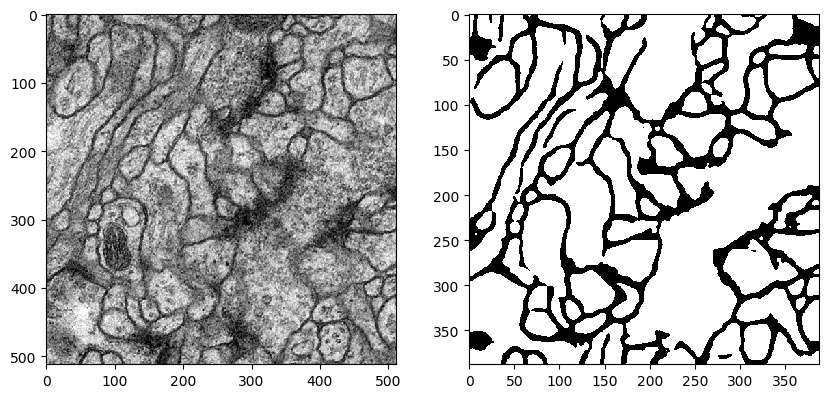

In [28]:
#在test_net原函数基础上调用测试数据集进行预测，并可视化预测结果
def test_net(data_dir, ckpt_path, cross_valid_ind=1, cfg=None):
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)
    criterion = CrossEntropyWithLogits()
    _, valid_dataset = create_dataset(data_dir, 1, 1, False, cross_valid_ind, False)
    model = Model(net, loss_fn=criterion, metrics={"dice_coeff": dice_coeff()})
    print("============== Starting Evaluating ============")
    dice_score = model.eval(valid_dataset, dataset_sink_mode=False)
    print("Cross valid dice coeff is:", dice_score)
    testimage=np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/test-volume.tif"))])

    #读取一张测试集图像
    testdata=testimage[10]
    image = Image.fromarray(testdata)
    #对图像进行缩放
    image = image.resize((388, 388))
    testdata = np.asarray(image)

    #对原图进行扩充，通过 numpy 的 pad 函数，将原图像边缘像素“外翻”，将 388*388 的图像扩充至 572*572。
    testdata = np.pad(testdata, ((92, 92),(92, 92) ),	'symmetric')

    #和训练时一样进行归一化处理
    testdata = testdata/127.5-1
    testdata = testdata.astype(np.float32)
    testdata = testdata.reshape(1,1,572,572)
    output = model.predict(Tensor(testdata))
    pred = np.argmax(output.asnumpy(), axis=1)
    pred = pred.reshape(388, 388)

    #可视化测试图像和模型推理结果。
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(testimage[10],cmap='gray')

    plt.subplot(2,2,2)
    plt.imshow(pred,cmap='gray')

    plt.show()

ckpt_path = './ckpt_2/ckpt_unet_medical_adam-2_600.ckpt'
test_net(data_dir=data_url, ckpt_path=ckpt_path, cross_valid_ind=cfg_unet['cross_valid_ind'], cfg=cfg_unet)
